<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Filtering" data-toc-modified-id="Filtering-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Filtering</a></span></li><li><span><a href="#Segmentation-into-beats" data-toc-modified-id="Segmentation-into-beats-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Segmentation into beats</a></span></li><li><span><a href="#Identify-dicrotic-notch-and-diastolic-peak" data-toc-modified-id="Identify-dicrotic-notch-and-diastolic-peak-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Identify dicrotic notch and diastolic peak</a></span></li></ul></li><li><span><a href="#Feature-extraction" data-toc-modified-id="Feature-extraction-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Feature extraction</a></span><ul class="toc-item"><li><span><a href="#Features" data-toc-modified-id="Features-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Features</a></span></li><li><span><a href="#Normalize--to-0-mean-and-variance" data-toc-modified-id="Normalize--to-0-mean-and-variance-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Normalize  to 0 mean and variance</a></span></li></ul></li><li><span><a href="#Prepare-dataset" data-toc-modified-id="Prepare-dataset-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Prepare dataset</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model</a></span></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
import scipy as sc

from scipy.signal import butter, filtfilt, find_peaks, peak_prominences
from scipy import integrate
from sklearn.preprocessing import normalize, StandardScaler

import heartpy as hp

from matplotlib import pyplot as plt

This notebook attempts blood pressure estimation from rPPG signal (remote PPG). On the basis of https://arxiv.org/pdf/1705.04524v3.pdf article here LSTMs are used on extracted features from signal.

The PPG measures the discoloration of the skin as blood perfuses through the capillaries and arteries after each heartbeat. The signal consists of the systolic peak, dicrotic notch, and the diastolic peak. When extracting heart beats, the systolic peaks are used. 

# Load data

In [2]:
def read_data(path, idxs):
    '''
    Returns array of signals from path directory. Filenames should be indexes stored in idxs argument (303.csv). 
    Shape is (n_s, l_s), where n_s - number of signals in directory, l_s - samples in signal
    '''
    df = [pd.read_csv(path+str(idx)+".csv")["pos"].to_numpy() for idx in idxs]
    return df

In [3]:
train_info = pd.read_csv("./ml_assignment_data/train/info.csv")

test_info = pd.read_csv("./ml_assignment_data/test/info.csv")

In [4]:
y_train = [train_info['systolic_pressure'].values, train_info['diastolic_pressure'].values]
idx_train = train_info['sampleID'].values

y_test = [test_info['systolic_pressure'].values, test_info['diastolic_pressure'].values]
idx_test = test_info['sampleID'].values

In [5]:
train_data = read_data("./ml_assignment_data/train/rPPG/", idx_train)
test_data = read_data("./ml_assignment_data/test/rPPG/", idx_test)

Functions will be tested on single signal from 303.csv file

In [6]:
# SAMPLE TO TEST
df = pd.read_csv("./ml_assignment_data/train/rPPG/303.csv")

# Preprocessing
## Filtering

Signals need to be filtered before extracting relevant features. Using 4 order Butterworth filter with cutoff 0.5 - 4Hz, which is a standard for PPG signal. Applied foward and backward filtering using filtfilt() scipy function.

In [8]:
def sampling_freq(signal, time=120):
    ''' Returns ampling frequency of the signal (as it may differ between recordings)'''
    
    return int(len(signal)/time)

def butter_bandpass(lowcut, highcut, fs, order=4):
    ''' Returns butterworth bandpass filter for parameters '''
    
    # nyquist freq - half of the sampling frequency
    nyq = 0.5 * fs
    
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    
    return b, a

def apply_filtering(signal):
    ''' Returns filtered signal '''
    # sampling freq
    fs = sampling_freq(signal)
    b, a = butter_bandpass(0.5, 4, fs, order=4)
    
    return filtfilt(b, a, signal)

In [11]:
# Apply butterworth filtering
fil = apply_filtering(df["pos"].values)

(0, 500)

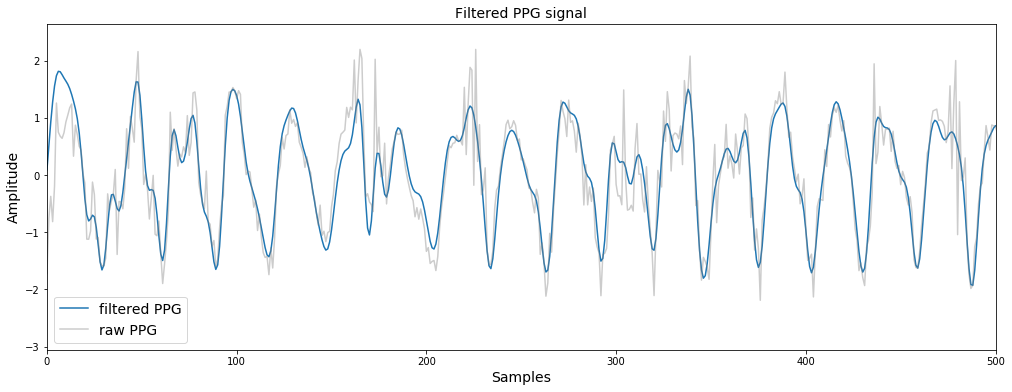

In [12]:
# Visualize signal before and after filtering
plt.figure(figsize=(17,6))

plt.plot(fil, label="filtered PPG")
plt.plot(df["pos"], c='gray', alpha=0.4, label="raw PPG")
plt.title("Filtered PPG signal", fontsize=14)
plt.xlabel("Samples", fontsize=14)
plt.ylabel("Amplitude", fontsize=14)
plt.legend(prop={'size':14})
plt.xlim(0,500)

The noise is significantly reduced. However further filtering might help to smooth out peaks (merge into one, those who are "separated") and result in better systolic peak detection. (median filter, convolve?)

## Segmentation into beats
Signal must be segmented into single beats. Beats are determined by tfns points. Before segmentation those points, including systolic peaks must be detected.
* For systolic peaks detection I tried to use heartpy toolkit, designed for PPG data to get systolic peaks, but somehow simple find_peaks() from scipy worked better.
* To get single beat I used local minima extraction that should be start/end of the beats. So they would be tfn points in the article.
* Then check if between two tfn points there is systolic beat. If the condition is met it's a beat.
* Each beat is normlized to 1-0 values

In [13]:
def systolic_peaks(signal):
    ''' Returns list of found systolic peaks in whole signal. Identified as maxima. Required distance between peaks set to 22'''
    return find_peaks(signal, distance=22)[0]

def tfn_points(signal):
    ''' Returns list of tfn points (beats boundaries) as minimums of signal with distance min 25 between eachother'''
    
    # here I use reverted signal and get peaks above 0 
    return find_peaks(signal*(-1), height=0, distance=25)[0]

def beat_segmentation(signal):
    
    ''' Returns list of beats from signal and list of corresponding systolic peak index'''
    
    systolics = systolic_peaks(signal)
    tfns = tfn_points(signal)
    
    beats, systolic = [], []
    
    for i in range(len(tfns)-1):
        start = tfns[i]
        end = tfns[i+1]
        segment = np.arange(start, end)
        l = [f in systolics for f in segment]
        
        # if there is only one systolic peak between minima its a beat
        if list(map(bool, l)).count(True) == 1: 
            # apply normalization, reshaping is required
            bshape = signal[segment].shape
            normalized_beat = normalize(signal[segment].reshape(1, -1))
            beats.append(normalized_beat.reshape(bshape))
            systolic.append(np.where(l)[0][0])
            
    
    return beats, systolic

(1500, 2000)

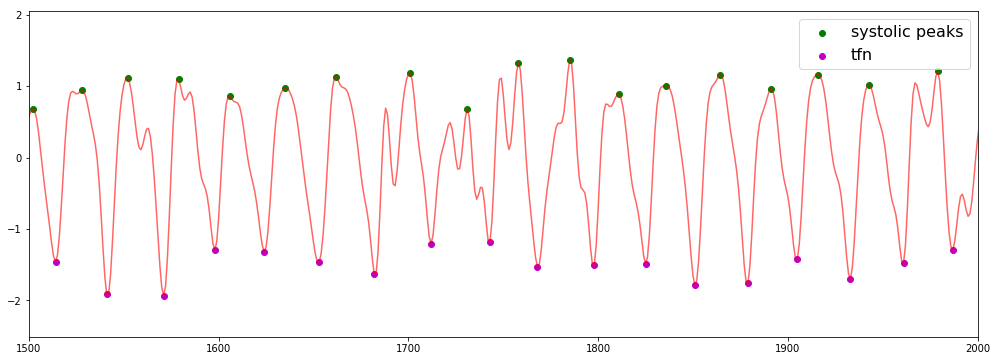

In [14]:
# Visualize detection of points
systolics = systolic_peaks(fil)
tfns = tfn_points(fil)


plt.figure(figsize=(17,6))
plt.plot(fil, c="r", alpha=0.6)

plt.scatter(systolics, fil[systolics], c="g", label="systolic peaks")
plt.scatter(tfns, fil[tfns], c="m", label="tfn")
plt.legend(prop={'size':16})
plt.xlim(1500,2000)

In [15]:
beats, systolics = beat_segmentation(fil)

## Identify dicrotic notch and diastolic peak
Two other critical points that must be detected before feature extraction are diastolic peaks and dicrotic notch. If a beat doesn't have those points indetified it's impossible to calculate some of the features. They are harder to find in signal than systolics and tfns, especially on the extact positions in noisy signal. Proposed methods:
* dicrotic notch - maximum of beat second derivative (starting from systolic peak). If more than one such point is identified, the one that occurs later in signal is taken.
* diastolic peak - maximum of inverted second order derivative of the part of the beat after systolic peak. Point is classified as dystolic peak if it's value bigger than 1% of the preceeding value. Inspiration reference: https://affect.media.mit.edu/pdfs/14.McDuff_et_al_Remote.pdf
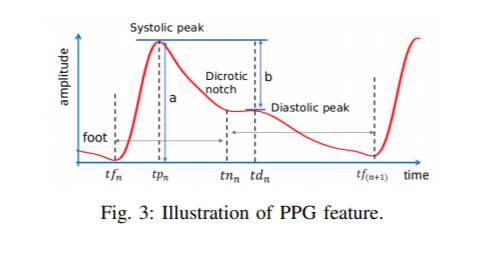

In [16]:
def dicrotic_notch(beat, systolic):
    '''Returns index of detected dicrotic notch in a beat. If not found returns 0'''
    
    derviative = np.diff(np.diff(beat[systolic:]))
    point = find_peaks(derviative)[0]
    corrected = 0
    
    if len(point) > 0:
        corrected =  systolic + point[-1]
        
    return corrected

def diastolic_peak(beat, systolic):
    '''Returns index of detected diastolic peak in a beat. If not found returns 0'''
   
    derviative = np.diff(np.diff(beat[systolic:]))
    point = find_peaks(derviative*(-1))[0]
    corrected = 0
    
    if len(point) > 0:
        corrected = systolic + point[-1]
        if abs(beat[corrected]) >= abs(1.01*beat[corrected - 1]):
            return corrected
        else: return 0
        
    return corrected

In [17]:
def second_derivative(y, x):
    '''Helper function: other way to calculate derivatives'''
    # first derivative dy/dx
    dy=np.diff(y)
    dx=np.diff(x)
    yfirst=dy/dx
    xfirst=0.5*(x[:-1] + x[1:])

    #second derivative
    dyfirst=np.diff(yfirst)
    dxfirst=np.diff(xfirst)
    ysecond=dyfirst/dxfirst
    xsecond=0.5*(xfirst[:-1] + xfirst[1:])
    
    return ysecond, xsecond

In [168]:
ysecond, xsecond = second_derivative(fil, df["Unnamed: 0"].values)

from scipy.ndimage.filters import uniform_filter1d
ysmooth = uniform_filter1d(ysecond, size=4)
maximus = signal.argrelextrema(ysmooth*(-1), np.greater)[0]
diastolic = []

for i in range(len(maximus)-1):
    if ysmooth[maximus[i+1]]+0.01*np.max(ysmooth) < ysmooth[maximus[i]]:
        diastolic.append(maximus[i+1])


excluded = [f for f in maximus if f not in diastolic]

gig,ax = plt.subplots(2,1,figsize=(17,6))
ax[0].plot(fil)
ax[0].scatter(systolic,fil[systolic],c='g')
ax[0].scatter(diastolic, fil[diastolic], c="m")
ax[0].scatter(excluded, fil[excluded], c ="r", alpha=0.5)
#ax[1].plot(ysecond)
ax[1].plot(ysmooth, c='r', alpha=0.5)
ax[1].scatter(systolic,ysmooth[systolic],c='g')
ax[1].scatter(diastolic, ysmooth[diastolic], c ="m")
plt.xlim(1000,1500)
ax[0].set_xlim(1000,1200)

In [18]:
def peaks_detection(beats, systolics):
    '''Returns created dataframe with beat values and critical points indices'''
    
    dicrotics = []
    diastolics = []
    
    for b, s in zip(beats, systolics):
        tnn = dicrotic_notch(b,s)
        tdn = diastolic_peak(b,s)
        
        dicrotics.append(tnn)
        diastolics.append(tdn)
    
    result = np.array([beats, systolics, dicrotics, diastolics], dtype=object)
    # remove those where dicrotics and diastolics weren't found
    result = result[..., result[2] > 0]
    result = result[..., result[3] > 0]
    
    # output shape is (4, nb) where nb is number of beats
    return result.T

In [19]:
beats_features = peaks_detection(beats, systolics)

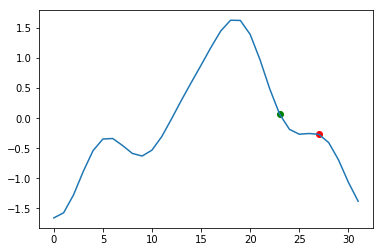

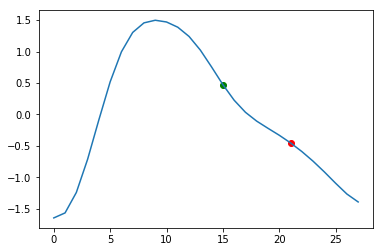

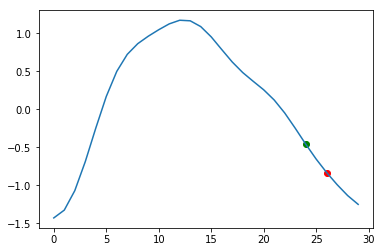

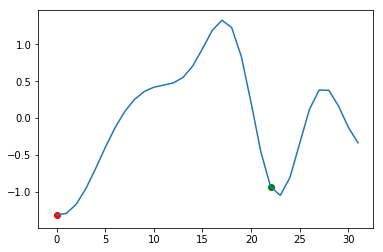

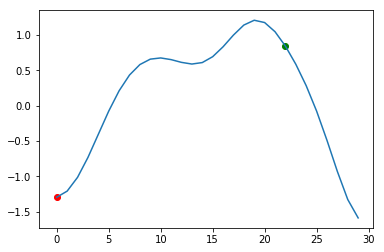

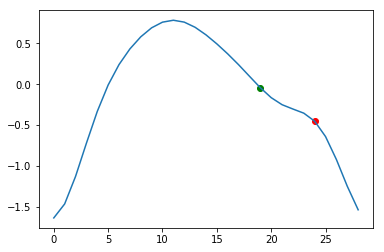

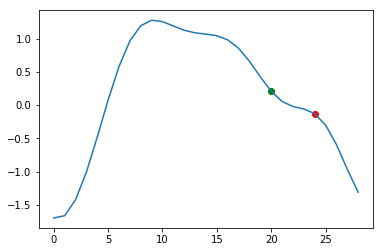

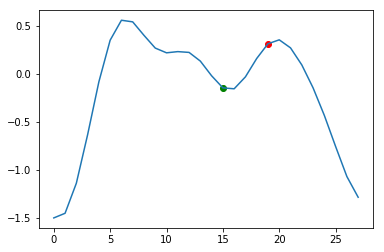

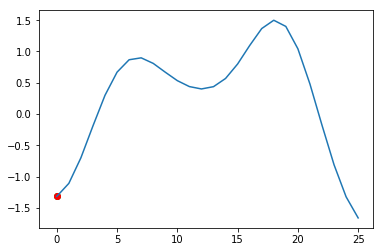

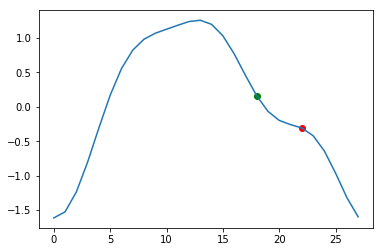

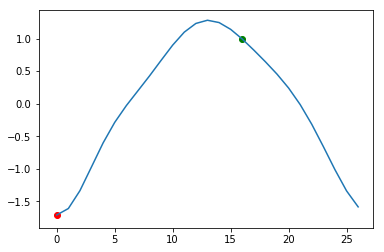

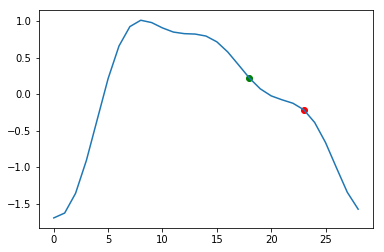

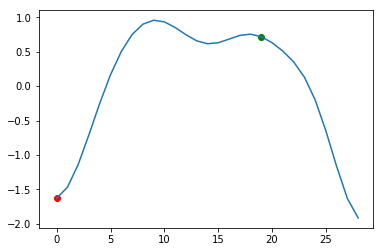

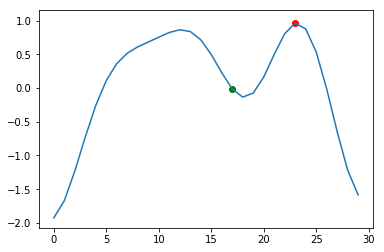

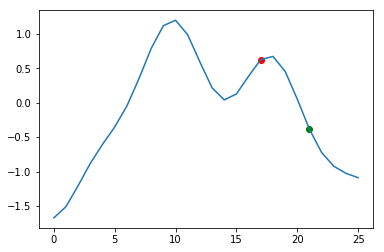

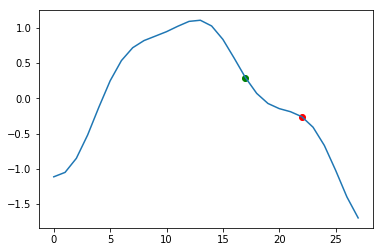

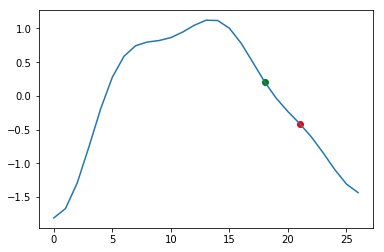

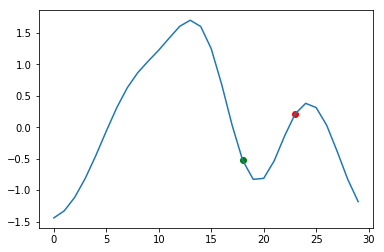

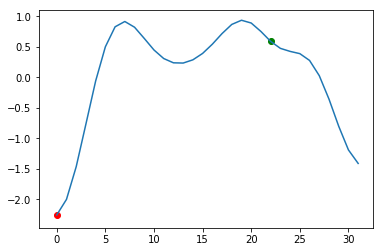

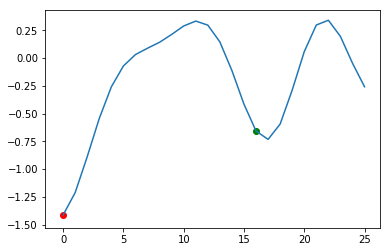

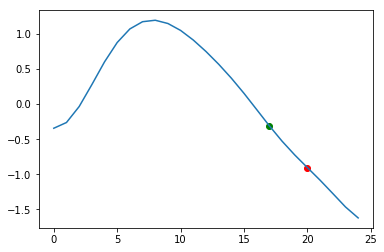

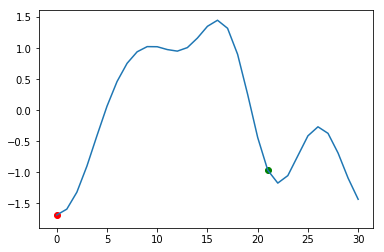

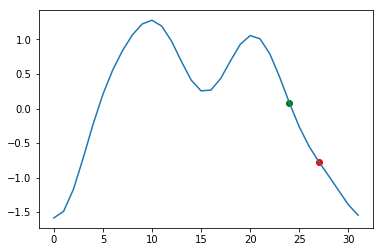

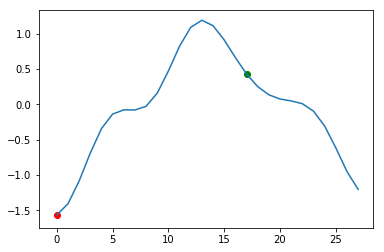

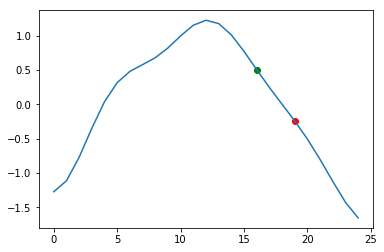

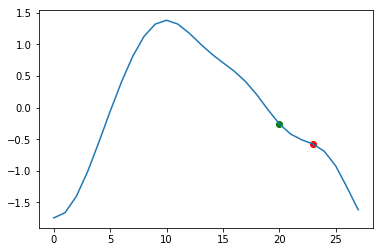

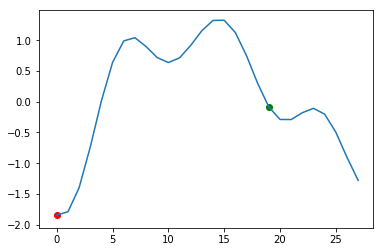

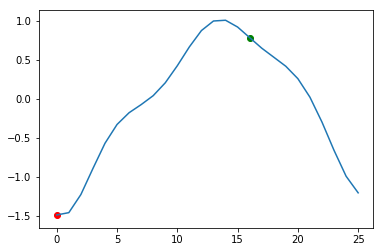

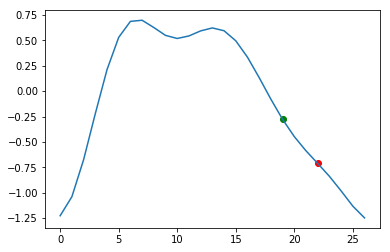

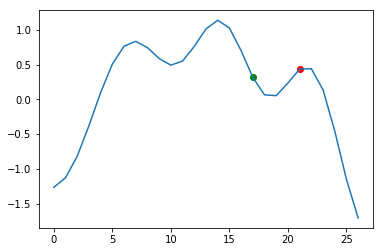

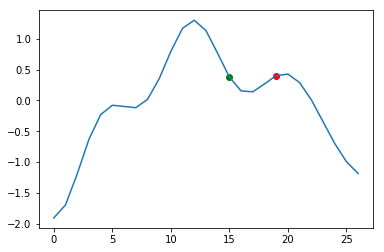

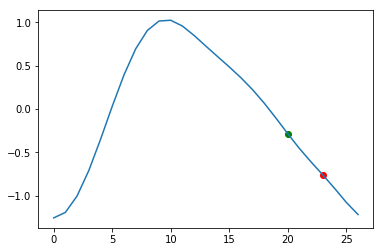

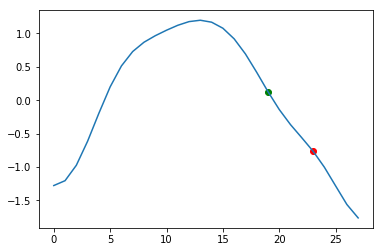

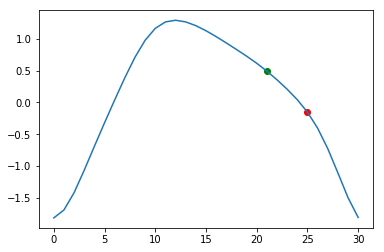

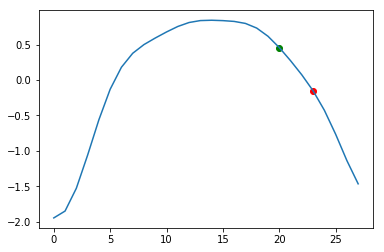

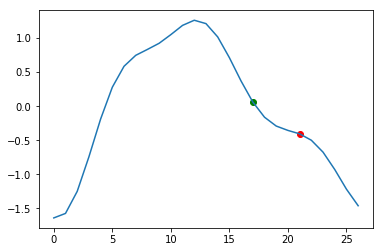

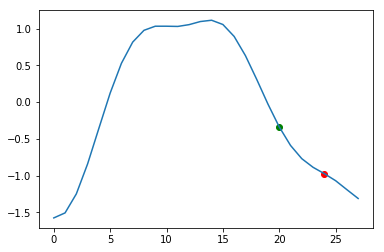

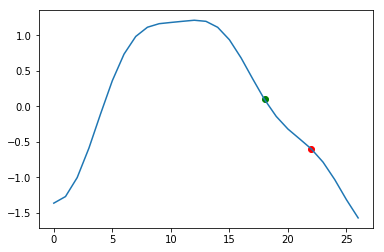

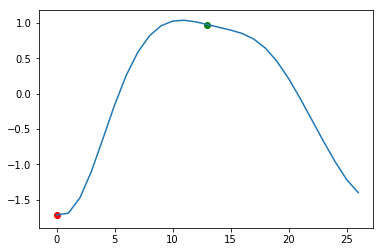

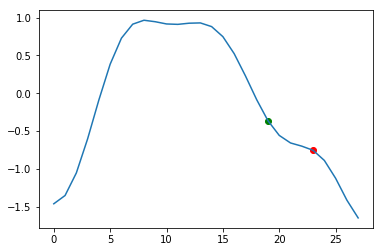

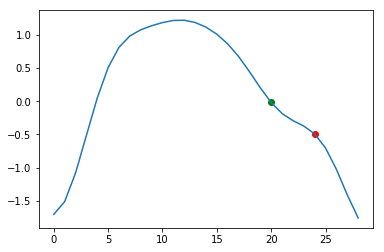

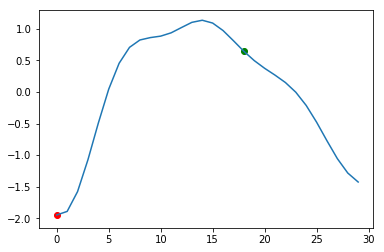

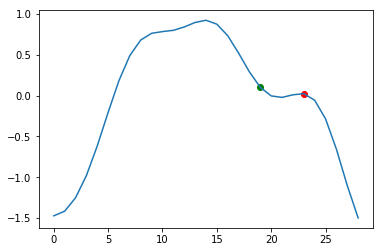

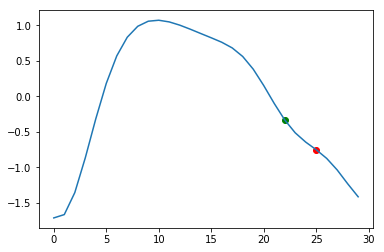

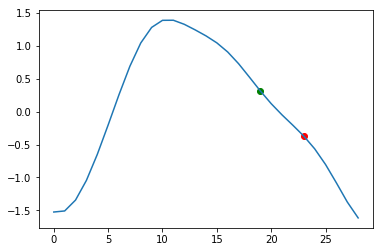

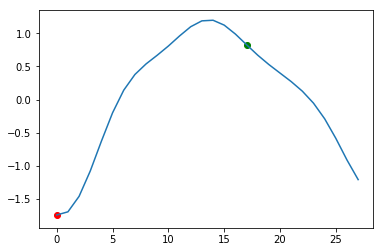

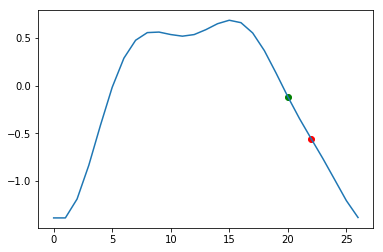

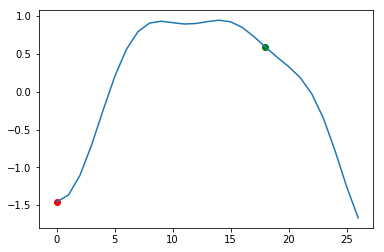

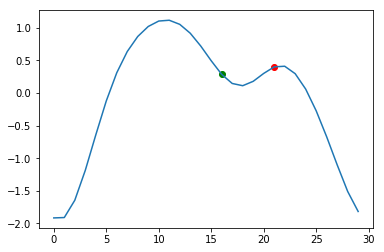

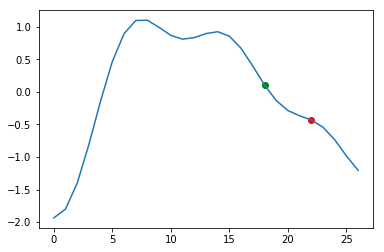

In [485]:
# Visualize some of the beats with detected critical points
for b, s in zip(beats[:50],systolics[:50]):
    tpn = dicrotic_notch(b,s)
    dis = diastolic_peak(b,s)
    plt.figure()
    plt.plot(b)
    plt.scatter(tpn,b[tpn], c="g")
    plt.scatter(dis,b[dis], c= "r")

# Feature extraction

## Features
Features are extracted based on peak localization for single beat. Heart rate is the based on whole signal however instead of beats (based on systolic points - regardless if after single points notch/diastolics are detected). Features used in the article are as follows:

- Heart rate: $HR$ 
- Reflection index: $RI = b/a$
- Systolic timespan: $ST = tn_n − tf_n$
- Up time: $ upTime = tp_n − tf_n$
- Systolic volume: $SV = \int_{tf_{n}}^{tn{n}} PPG(t)dt$
- Diastolic volume: $DV = \int^{tf_{n+1}}_{tn{n}} PPG(t)dt$


In [20]:
def heart_rate(signal, fs):
    ''' Number of systolic peaks per minute. Normal between 60-100 bpm'''
    
    fs = sampling_freq(signal)
    
    sys = systolic_peaks(signal)
    T = len(signal)/fs
    
    return len(sys)/(T/60)

def reflection_index(beat, systolic, diastolic):
    a = beat[systolic] - np.min(beat)
    b = a - (beat[diastolic] - np.min(beat))
    
    return a/b

def systolic_timespan(beat, dicrotic,fs):
    return dicrotic/fs

def up_time(systolic, fs):
    return systolic/fs
    
def systolic_volume(beat, dicrotic, fs):
    return integrate.simps(beat[:dicrotic], dx=1/fs)
    
def diastolic_volume(beat, dicrotic, fs):
    
    return integrate.simps(beat[dicrotic:], dx=1/fs)

In [21]:
def extract_features(signal, beats_arr, fs):
    '''Extract features from beat array consisting of beat values, systolic peak index, dicrotic notch index and diastolic peak index'''
    
    features = []
    
    hr = heart_rate(signal, fs)
    
    for data in beats_arr:
        beat = data[0]
        systolic = data[1]
        dicrotic = data[2]
        diastolic = data[3]
        
        ri = reflection_index(beat, systolic, diastolic)
        st = systolic_timespan(beat, dicrotic,fs)
        ut = up_time(systolic, fs)
        sv = systolic_volume(beat, dicrotic, fs)
        dv = diastolic_volume(beat, dicrotic, fs)

        features.append([hr, ri, st, ut, sv, dv])
    
    # transpose to change shape to be (7, Tx)
    return np.array(features).T

In [751]:
features = extract_features(fil, beats_features, fs)

## Normalize  to 0 mean and variance
Now input $X_T$ becomes a (6,T) matrix, and each row
of  $X_T$ is normalized to have zero-mean and unit-variance.

In [22]:
def norm_zeromean(data):
    scaler = StandardScaler(with_mean=False)
    normalized = [np.array(scaler.fit_transform(col.reshape(-1, 1))) for col in data]
    
    # get rid of third dimension 1 (6, Tx, 1)
    return np.squeeze(normalized)

In [800]:
X = norm_zeromean(features)

# Prepare dataset

In [7]:
def process_signal(data):
    fs = sampling_freq(data)
    
    filtered = apply_filtering(data)
    beats, sys = beat_segmentation(data)
    peaks = peaks_detection(beats, sys)
    features = extract_features(filtered, peaks, fs)
    norm = norm_zeromean(features)
    
    return norm

def prepare_dataset(data):
    
    return [process_signal(sample) for sample in data]

In [23]:
X = prepare_dataset(train_data)

In [28]:
np.array(X[8]).shape

(6, 35)

# Model

As the data is time series sequence RNN is the best choice.
Model was built in keras. Inspired by the article, but not exact. Same as described in it bidirectional LSTM is used as the first layer. Oher layers consist of normal LSTM cells. 
X must be of dimension (m, Tx, n_values)
(291,beats?,6)

In [34]:
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras import Input, Model

In [31]:
# number of dimensions for the hidden state of each LSTM cell.
n_a = 128

#The sequence length T of each training sample is set to 32, and it could be larger if deeper model is adopted

m = len(X)
a0 = np.zeros((m, n_a))
c0 = np.zeros((m, n_a))

In [35]:
inputs = Input(shape=(m,6,None))
x = Bidirectional(LSTM(128, return_sequences=True))(X)
x = Dropout(rate=0.4)(x)
x = LSTM(128, return_sequences=False)(x)
x = Dropout(rate=0.5)(X)
x = LSTM(128, return_sequences=False)(x)
X = Dropout(rate=0.5)(X)
x = LSTM(128, return_sequences=False)(x)
x = Dropout(rate=0.5)(x)
outputs = Dense(units=5, activation='softmax')(x)

model = Model(inputs, outputs)

ValueError: Unexpectedly found an instance of type `<class 'numpy.ndarray'>`. Expected a symbolic tensor instance.

In [ ]:
# Adam optimizer
opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)

model.compile(optimizer=opt, loss='mean_absolute_error', metrics=['rmse', 'mae','accuracy'])

In [ ]:
model.fit([X, a0, c0], list(Y), epochs=100, batch_size=64)
model.fit(x_train, y_train, batch_size=64, epochs=100)